In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm

In [33]:
def load_embeddings(experiment_dir, layer_names):
    """
    Load embeddings for specified layers from a given experiment directory.
    """
    embeddings = {}
    for layer in layer_names:
        layer_path = os.path.join(experiment_dir, f"{layer}.npy")
        if os.path.exists(layer_path):
            embeddings[layer] = np.load(layer_path)
        else:
            print(f"Warning: {layer_path} not found.")
    return embeddings

def compute_sorted_eigenvalues(embeddings, center=True):
    """
    Computes the eigenvalues of the covariance matrix of the embeddings.
    
    Args:
        embeddings (np.ndarray): Array of shape [num_examples, representation_dim].
        center (bool): If True, subtract the mean of each column.
    
    Returns:
        sorted_eigvals (np.ndarray): Eigenvalues sorted in descending order.
    """
    # Center the embeddings if required.
    if center:
        X_centered = embeddings - np.mean(embeddings, axis=0, keepdims=True)
    else:
        X_centered = embeddings
    
    # Compute the covariance matrix. Using rowvar=False means each column is a variable.
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    # For a symmetric covariance matrix, use eigh (which returns real eigenvalues)
    eigvals, _ = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues in descending order
    sorted_eigvals = np.sort(eigvals)[::-1]
    return sorted_eigvals

def plot_scree(sorted_eigvals, layer_name="Layer", model_name="Model", cumulative=False):
    """
    Plots a scree plot of the sorted eigenvalues.
    
    Args:
        sorted_eigvals (np.ndarray): Sorted eigenvalues (descending order).
        layer_name (str): Name of the layer (for the title).
        model_name (str): Name of the model (for the title).
        cumulative (bool): If True, plots cumulative explained variance.
    """
    indices = np.arange(1, len(sorted_eigvals) + 1)
    
    if cumulative:
        # Compute cumulative explained variance
        cum_explained = np.cumsum(sorted_eigvals) / np.sum(sorted_eigvals)
        plt.figure(figsize=(8, 6))
        plt.plot(indices, cum_explained, marker='o', linestyle='-')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title(f"Cumulative Explained Variance\n{model_name} - {layer_name}")
        plt.grid(True)
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        plt.plot(indices, sorted_eigvals, marker='o', linestyle='-')
        plt.xlabel("Component Index")
        plt.ylabel("Eigenvalue")
        plt.title(f"Scree Plot\n{model_name} - {layer_name}")
        plt.grid(True)
        plt.show()

def compute_effective_rank(sorted_eigvals):
    """
    Computes the effective rank of the representation based on the eigenvalue spectrum.
    
    Effective rank is defined as exp(-∑ p_i log(p_i)), where p_i are the normalized eigenvalues.
    
    Args:
        sorted_eigvals (np.ndarray): Sorted eigenvalues (descending order).
        
    Returns:
        effective_rank (float): The effective rank of the representation.
    """
    eps = 1e-12  # small constant to avoid division by zero and log(0)
    total = np.sum(sorted_eigvals) + eps
    p = sorted_eigvals / total
    entropy = -np.sum(p * np.log(p + eps))
    effective_rank = np.exp(entropy)
    return effective_rank

def extract_label(exp_dir):
    match = re.search(r'cut_tree_\d+', exp_dir)
    if match:
        return match.group(0)
    return os.path.basename(exp_dir)

def plot_effective_rank_vs_layer_multi(experiment_dirs, layer_names, model_label_func=None):
    """
    For a list of experiment directories (each corresponding to one model),
    load the embeddings for the given layers, compute the effective rank for each layer,
    and plot effective rank vs. layer for all models in one plot.
    
    Args:
        experiment_dirs (list): List of experiment directory paths.
        layer_names (list): List of layer names (order is preserved).
        model_label_func (callable, optional): A function that takes an experiment directory
            string and returns a label for that model. If None, the basename of the directory is used.
    """
    effective_ranks_dict = {}
    
    for exp_dir in experiment_dirs:
        # Load embeddings for the model
        embeddings = load_embeddings(exp_dir, layer_names)
        effective_ranks = []
        for layer in layer_names:
            if layer in embeddings:
                # embeddings[layer] is assumed to have shape [num_examples, representation_dim]
                sorted_eigvals = compute_sorted_eigenvalues(embeddings[layer])
                eff_rank = compute_effective_rank(sorted_eigvals)
                effective_ranks.append(eff_rank)
            else:
                effective_ranks.append(np.nan)
        
        # Generate a label for this model
        if model_label_func is not None:
            label = model_label_func(exp_dir)
        else:
            # Default: use the basename of the directory
            label = os.path.basename(exp_dir)
        effective_ranks_dict[label] = effective_ranks

    # Plot effective rank vs. layer for all models on one plot
    plt.figure(figsize=(12, 8))
    x = np.arange(len(layer_names))
    for label, eff_ranks in effective_ranks_dict.items():
        plt.plot(x, eff_ranks, marker='o', label=label)
    
    plt.xticks(x, layer_names, rotation=45, ha='right')
    plt.xlabel("Layer")
    plt.ylabel("Effective Rank")
    plt.title("Effective Rank vs. Layer Across Models")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def shared_subspace_analysis(X, Y, center=True):
    """
    Performs shared subspace analysis by projecting the eigenvectors of the covariance
    matrix of X onto the similarity matrix of Y.
    
    Args:
        X (np.ndarray): Activation matrix from model A of shape [num_examples, dim].
        Y (np.ndarray): Activation matrix from model B of shape [num_examples, dim].
        center (bool): If True, center the data by subtracting the mean.
    
    Returns:
        eigvals_sorted (np.ndarray): Sorted eigenvalues of S_X in descending order.
        projection_norms (np.ndarray): Norms of the projected eigenvectors from Y Y^T.
        cosines (np.ndarray): Cosine similarities between each eigenvector and its projection.
    """
    if center:
        X_centered = X - np.mean(X, axis=0, keepdims=True)
        Y_centered = Y - np.mean(Y, axis=0, keepdims=True)
    else:
        X_centered = X
        Y_centered = Y

    # Compute similarity (covariance) matrices:
    S_X = np.dot(X_centered, X_centered.T)
    S_Y = np.dot(Y_centered, Y_centered.T)
    
    # Eigen-decomposition of S_X (since it is symmetric, use eigh)
    eigvals, U = np.linalg.eigh(S_X)
    
    # Sort eigenvalues (and eigenvectors) in descending order:
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals_sorted = eigvals[sorted_indices]
    U_sorted = U[:, sorted_indices]
    
    projection_norms = []
    cosines = []
    
    # For each eigenvector u_i, compute the projection via S_Y:
    for i in range(U_sorted.shape[1]):
        u = U_sorted[:, i]
        v = np.dot(S_Y, u)
        norm_v = np.linalg.norm(v)
        projection_norms.append(norm_v)
        # Compute cosine similarity between u and v (if norm_v is near zero, set cosine to 0)
        if norm_v < 1e-12:
            cos_sim = 0
        else:
            cos_sim = np.dot(u, v) / norm_v
        cosines.append(cos_sim)
        
    return eigvals_sorted, np.array(projection_norms), np.array(cosines)

def plot_shared_subspace(eigvals, projection_norms, cosines, layer_name="Layer", model_pair="Model_A vs Model_B"):
    """
    Plots the results of the shared subspace analysis:
    - Left: A plot of eigenvalue (from S_X) and the norm of the projection (from S_Y u) versus eigenvalue rank.
    - Right: A plot of the cosine similarity versus eigenvalue rank.
    
    Args:
        eigvals (np.ndarray): Sorted eigenvalues from S_X.
        projection_norms (np.ndarray): Norms of the projections (||S_Y u_i||).
        cosines (np.ndarray): Cosine similarities between u_i and S_Y u_i.
        layer_name (str): Name of the layer being compared.
        model_pair (str): Label describing the pair of models (e.g. "Model_A vs Model_B").
    """
    ranks = np.arange(1, len(eigvals) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Left plot: eigenvalue vs. projection norm
    plt.subplot(1, 2, 1)
    plt.plot(ranks, eigvals, 'o-', label="||S_X u|| (Eigenvalue)")
    plt.plot(ranks, projection_norms, 's--', label="||S_Y u|| (Projection Norm)")
    plt.xlabel("Eigenvalue Rank")
    plt.ylabel("Magnitude")
    plt.title(f"Projection Norm vs. Eigenvalue Rank\n{layer_name} - {model_pair}")
    plt.legend()
    plt.grid(True)
    
    # Right plot: cosine similarity vs. eigenvalue rank
    plt.subplot(1, 2, 2)
    plt.plot(ranks, cosines, 'o-', color='green')
    plt.xlabel("Eigenvalue Rank")
    plt.ylabel("Cosine Similarity")
    plt.title(f"Cosine Similarity vs. Eigenvalue Rank\n{layer_name} - {model_pair}")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def compute_alignment_metric(X, Y, top_k=5, center=True):
    """
    Computes an aggregate alignment metric between representations X and Y for a given layer.
    It runs shared subspace analysis (as defined earlier) and returns the average cosine similarity
    over the top_k eigenvectors.
    
    Args:
        X (np.ndarray): Activation matrix from the reference model (shape: [num_examples, dim]).
        Y (np.ndarray): Activation matrix from the comparison model (shape: [num_examples, dim]).
        top_k (int): Number of top eigenvectors to consider.
        center (bool): Whether to center the data.
    
    Returns:
        float: Average cosine similarity over the top_k eigenvectors.
    """
    eigvals, proj_norms, cosines = shared_subspace_analysis(X, Y, center=center)
    # Take the top_k cosine similarities; if there are fewer than top_k, take them all.
    top_cos = cosines[:min(top_k, len(cosines))]
    return np.mean(top_cos)

def plot_alignment_vs_layer(reference_dir, compare_dirs, layer_names, top_k=5, model_label_func=None):
    """
    For a fixed reference model and a list of comparison models, load embeddings for each layer,
    compute an alignment metric (average cosine similarity from shared subspace analysis) for each layer,
    and then plot these metrics vs. layer (one curve per compare_dir) in a single plot.
    
    Args:
        reference_dir (str): Directory for the reference model.
        compare_dirs (list): List of directories for the models to compare.
        layer_names (list): List of layer names (order preserved).
        top_k (int): Number of top eigenvectors to consider in the alignment metric.
        model_label_func (callable, optional): Function that extracts a label from a directory string.
    """
    # Load reference embeddings once.
    ref_embeddings = load_embeddings(reference_dir, layer_names)
    
    # Dictionary to store alignment metrics for each compare model.
    alignment_dict = {}
    
    for comp_dir in compare_dirs:
        comp_embeddings = load_embeddings(comp_dir, layer_names)
        # Generate a label for this comparison model.
        if model_label_func is not None:
            label = model_label_func(comp_dir)
        else:
            label = os.path.basename(comp_dir)
        
        metrics = []
        # For each layer, compute the alignment metric between the reference and this model.
        for layer in layer_names:
            if layer in ref_embeddings and layer in comp_embeddings:
                X = ref_embeddings[layer]  # shape: [num_examples, dim]
                Y = comp_embeddings[layer]
                metric = compute_alignment_metric(X, Y, top_k=top_k, center=True)
                metrics.append(metric)
            else:
                metrics.append(np.nan)
        alignment_dict[label] = metrics
    
    # Plotting all curves on one plot.
    plt.figure(figsize=(12, 8))
    x = np.arange(len(layer_names))
    for label, metrics in alignment_dict.items():
        plt.plot(x, metrics, marker='o', label=label)
    
    plt.xticks(x, layer_names, rotation=45, ha='right')
    plt.xlabel("Layer")
    plt.ylabel("Average Top-{} Cosine Similarity".format(top_k))
    plt.title("Alignment Metric vs. Layer\n(Reference: " + os.path.basename(reference_dir) + ")")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compute_cum_explained_variance(embeddings, center=True, max_components=None):
    """
    Computes the cumulative explained variance curve for a given layer's embeddings.
    
    Args:
        embeddings (np.ndarray): Array of shape [num_examples, representation_dim].
        center (bool): If True, subtract the mean from each column.
        max_components (int, optional): If provided, limits the number of components shown.
    
    Returns:
        cum_explained (np.ndarray): 1D array of cumulative explained variance.
    """
    # Center the data if requested
    if center:
        X_centered = embeddings - np.mean(embeddings, axis=0, keepdims=True)
    else:
        X_centered = embeddings
        
    # Compute covariance matrix (each column is a variable)
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    # Compute eigenvalues using eigh (covariance matrix is symmetric)
    eigvals, _ = np.linalg.eigh(cov_matrix)
    sorted_eigvals = np.sort(eigvals)[::-1]  # descending order
    
    if max_components is not None:
        sorted_eigvals = sorted_eigvals[:max_components]
    
    cum_explained = np.cumsum(sorted_eigvals) / np.sum(sorted_eigvals)
    return cum_explained

def plot_avg_cum_explained_variance_multi(experiment_dirs, layer_names, max_components=50, center=True, model_label_func=None):
    """
    For each experiment directory (model), loads the embeddings for the given layers,
    computes the cumulative explained variance curve for each layer, averages these curves
    across layers, and then plots one curve per experiment.
    
    Args:
        experiment_dirs (list): List of experiment directory paths.
        layer_names (list): List of layer names (order is preserved).
        max_components (int): Number of components to include in the plot.
        center (bool): If True, center the data when computing covariance.
        model_label_func (callable, optional): Function that takes an experiment directory
            string and returns a label for that model. If None, the basename is used.
    """
    avg_cumvar_dict = {}
    
    for exp_dir in tqdm(experiment_dirs, desc="Processing experiments"):
        # Load embeddings for this experiment.
        embeddings = load_embeddings(exp_dir, layer_names)
        cumvar_curves = []
        
        for layer in layer_names:
            if layer in embeddings:
                emb = embeddings[layer]  # shape: [num_examples, representation_dim]
                cum_explained = compute_cum_explained_variance(emb, center=center, max_components=max_components)
                cumvar_curves.append(cum_explained)
            else:
                # If a layer is missing, ignore it (or append NaNs)
                continue
        
        if cumvar_curves:
            # Average the cumulative curves across layers (pointwise)
            avg_curve = np.mean(np.stack(cumvar_curves, axis=0), axis=0)
        else:
            avg_curve = np.zeros(max_components)
        
        # Generate a label for the experiment.
        if model_label_func is not None:
            label = model_label_func(exp_dir)
        else:
            label = os.path.basename(exp_dir)
        avg_cumvar_dict[label] = avg_curve

    # Plot the averaged cumulative explained variance curves for all experiments
    plt.figure(figsize=(12, 8))
    x = np.arange(1, max_components + 1)
    for label, avg_curve in avg_cumvar_dict.items():
        plt.plot(x, avg_curve, marker='o', label=label)
    
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Average Cumulative Explained Variance Across Layers\nfor Each Experiment")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def same_depth_label(exp_dir):
    base = os.path.basename(exp_dir).lower()
    if "dreams" in base:
        label = "dreams_embeddings"
    else:
        label = "raw_spectra"
    if "bonus" in base:
        label += "_formula"
    return label

In [7]:
# Specify the layers you want to compare
layer_names = ['gnn_1_head_1_mean',
'gnn_1_head_2_mean',
'gnn_1_head_3_mean',
'gnn_1_head_4_mean',
'gnn_2_head_1_mean',
'gnn_2_head_2_mean',
'gnn_2_head_3_mean',
'gnn_2_head_4_mean',
'gnn_3_head_1_mean',
'gnn_3_head_2_mean',
'gnn_3_head_3_mean',
'gnn_3_head_4_mean',
'head_head_fc1',
'head_skipblock_1_hidden1',
'head_skipblock_1_hidden2',
'head_skipblock_2_hidden1',
'head_skipblock_2_hidden2',
'head_skipblock_3_hidden1',
'head_skipblock_3_hidden2',
'head_skipblock_4_hidden1',
'head_skipblock_4_hidden2', 
'head_skipblock_5_hidden1',
'head_skipblock_5_hidden2',
'head_skipblock_6_hidden1',
'head_skipblock_6_hidden2',
'head_head_fc_final',
]

## DreaMS

In [8]:
experiment_dreams = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_14-51-13',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_15-31-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_16-12-30',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_16-56-31'
]

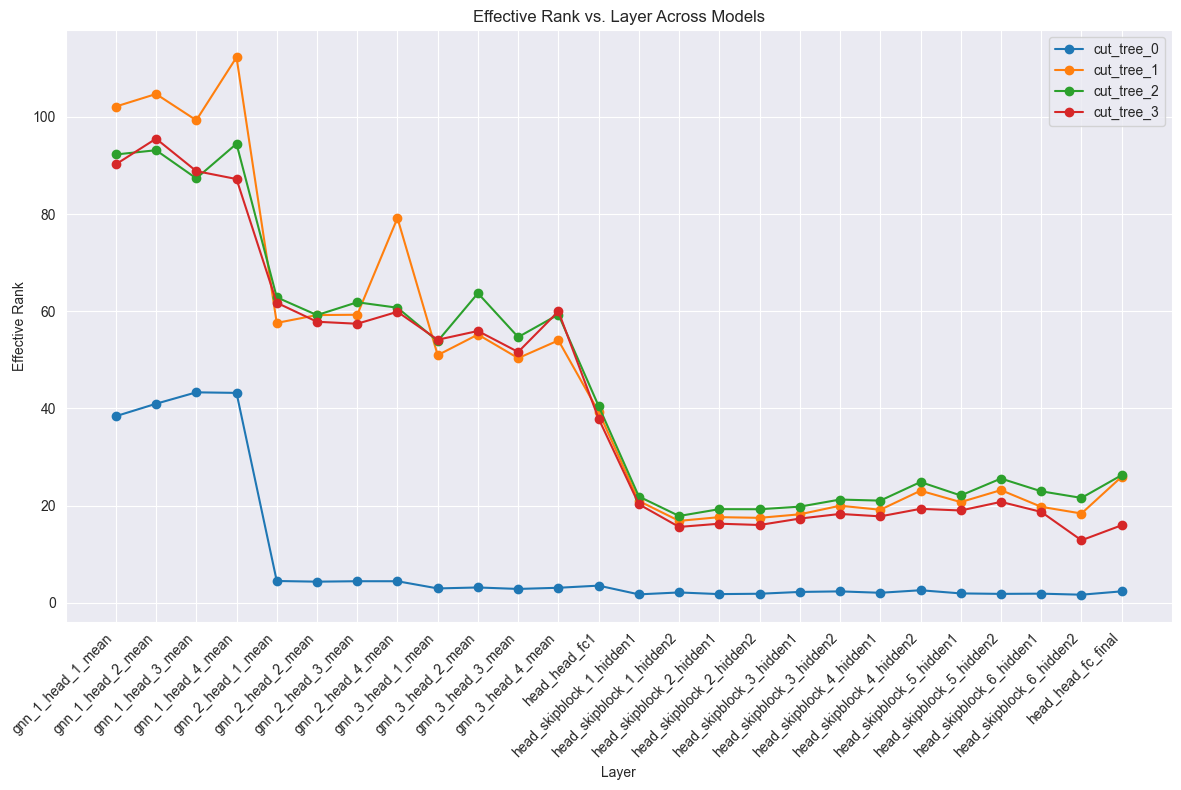

In [9]:
plot_effective_rank_vs_layer_multi(experiment_dreams, layer_names, model_label_func=extract_label)

Processing experiments: 100%|██████████| 4/4 [00:27<00:00,  6.88s/it]


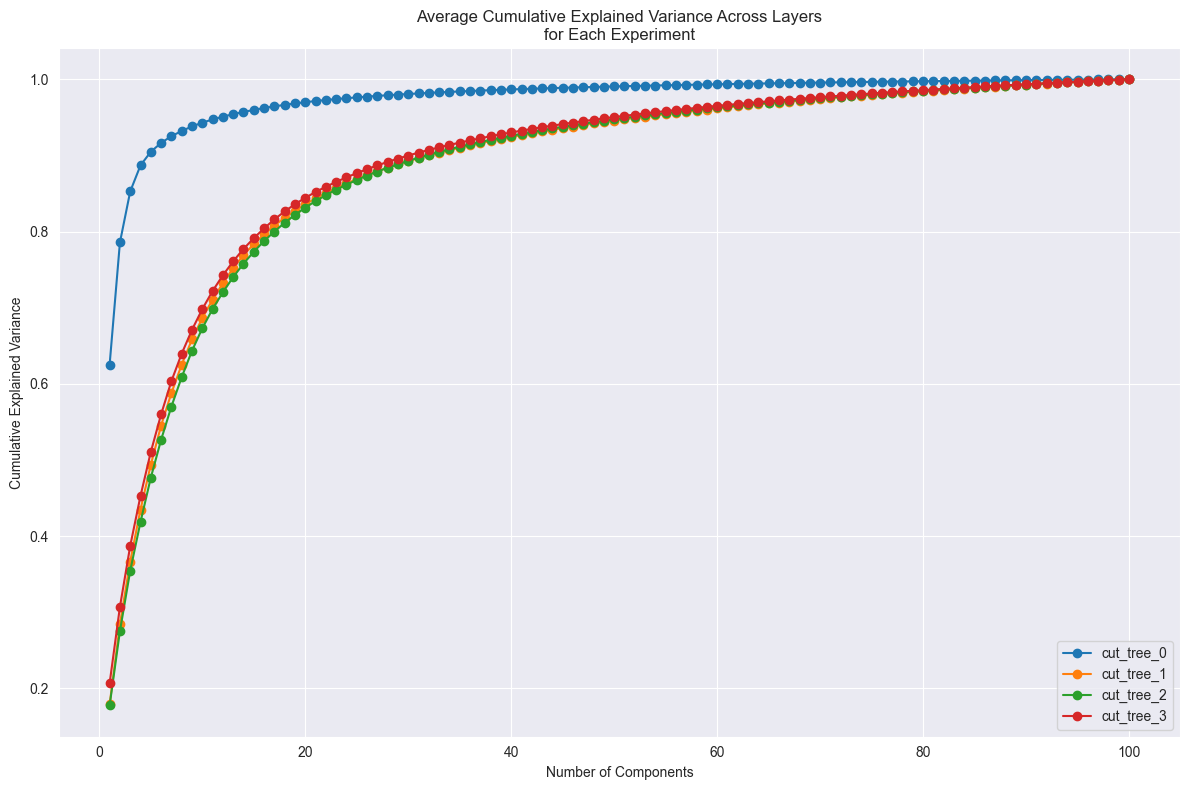

In [11]:
plot_avg_cum_explained_variance_multi(experiment_dreams, layer_names, max_components=100, center=True, model_label_func=extract_label)

## DreaMS Bonus

In [12]:
experiment_dreams_bonus = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_0_2025-02-19_17-38-07',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_1_2025-02-19_18-24-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_2_2025-02-19_19-10-33',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_3_2025-02-19_19-57-08'
]

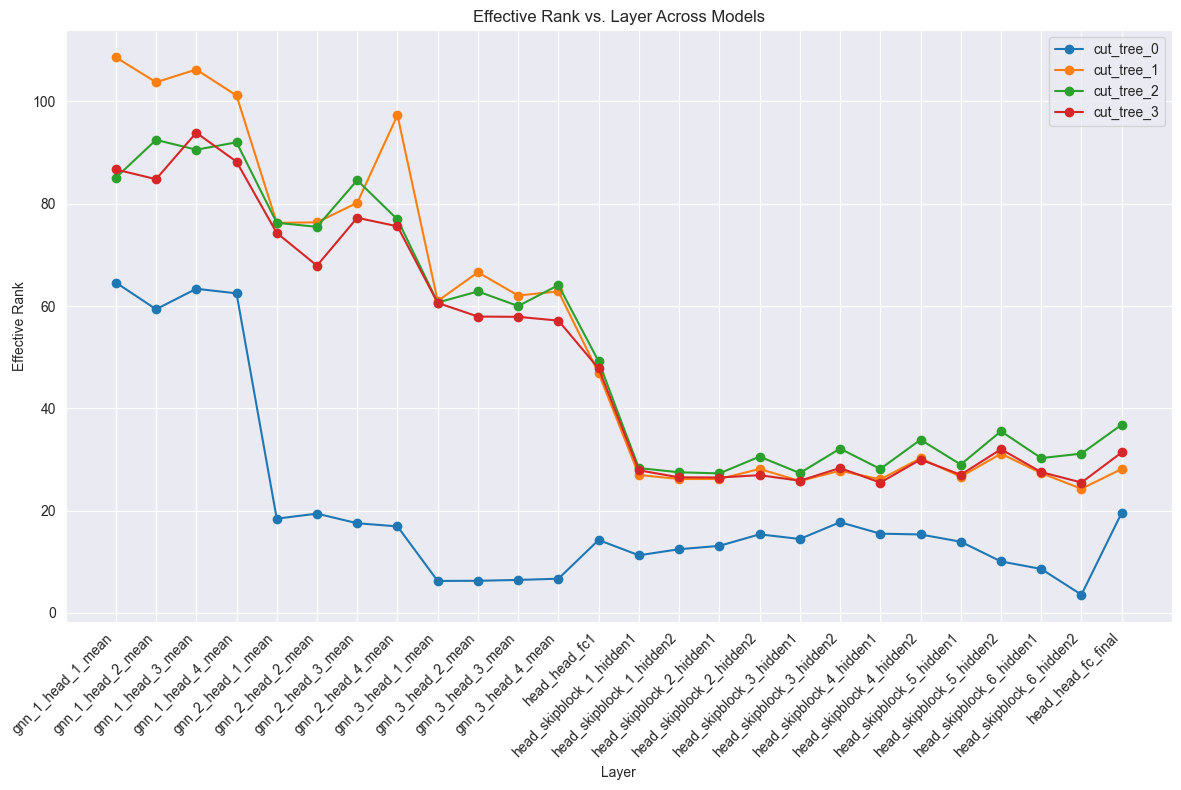

In [13]:
plot_effective_rank_vs_layer_multi(experiment_dreams_bonus, layer_names, model_label_func=extract_label)

Processing experiments: 100%|██████████| 4/4 [00:24<00:00,  6.24s/it]


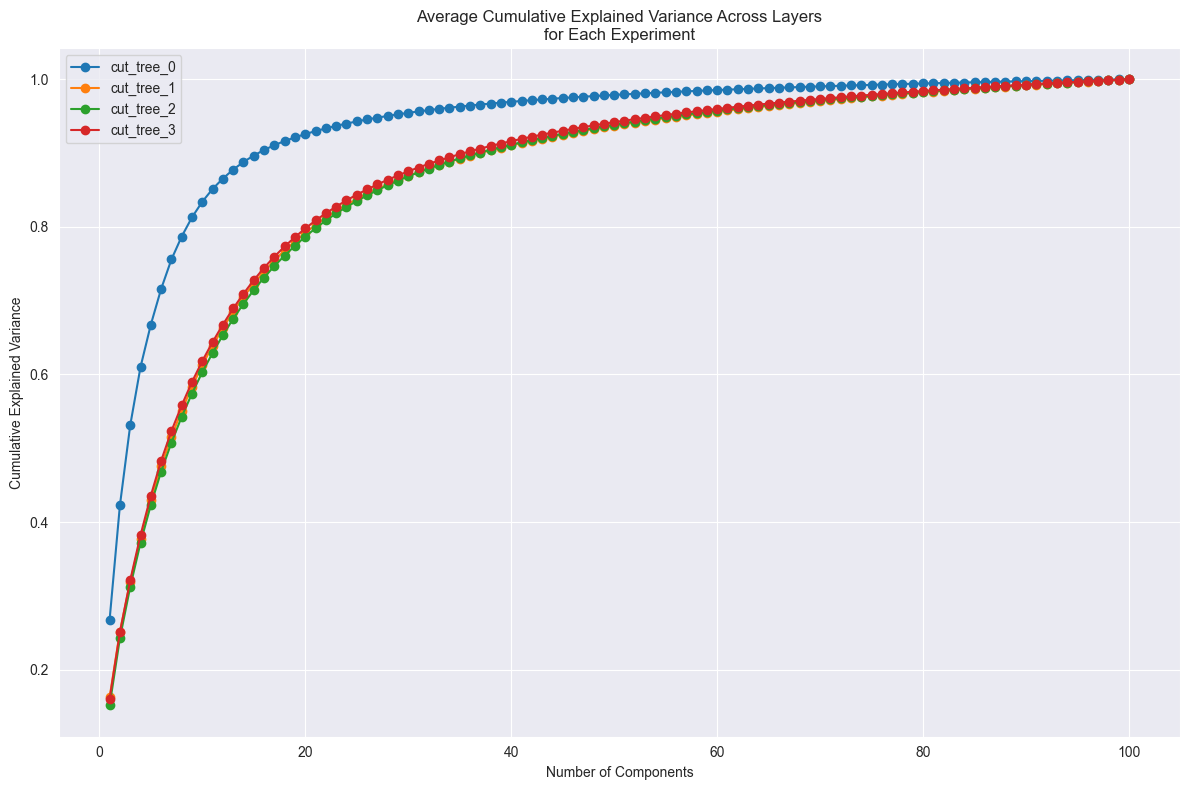

In [14]:
plot_avg_cum_explained_variance_multi(experiment_dreams_bonus, layer_names, max_components=100, center=True, model_label_func=extract_label)


## Raw Spectra

In [15]:
experiment_raw_spectra = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_0_2025-02-19_09-00-57',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_1_2025-02-19_09-38-36',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_2_2025-02-19_10-20-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_3_2025-02-19_11-02-28'
]

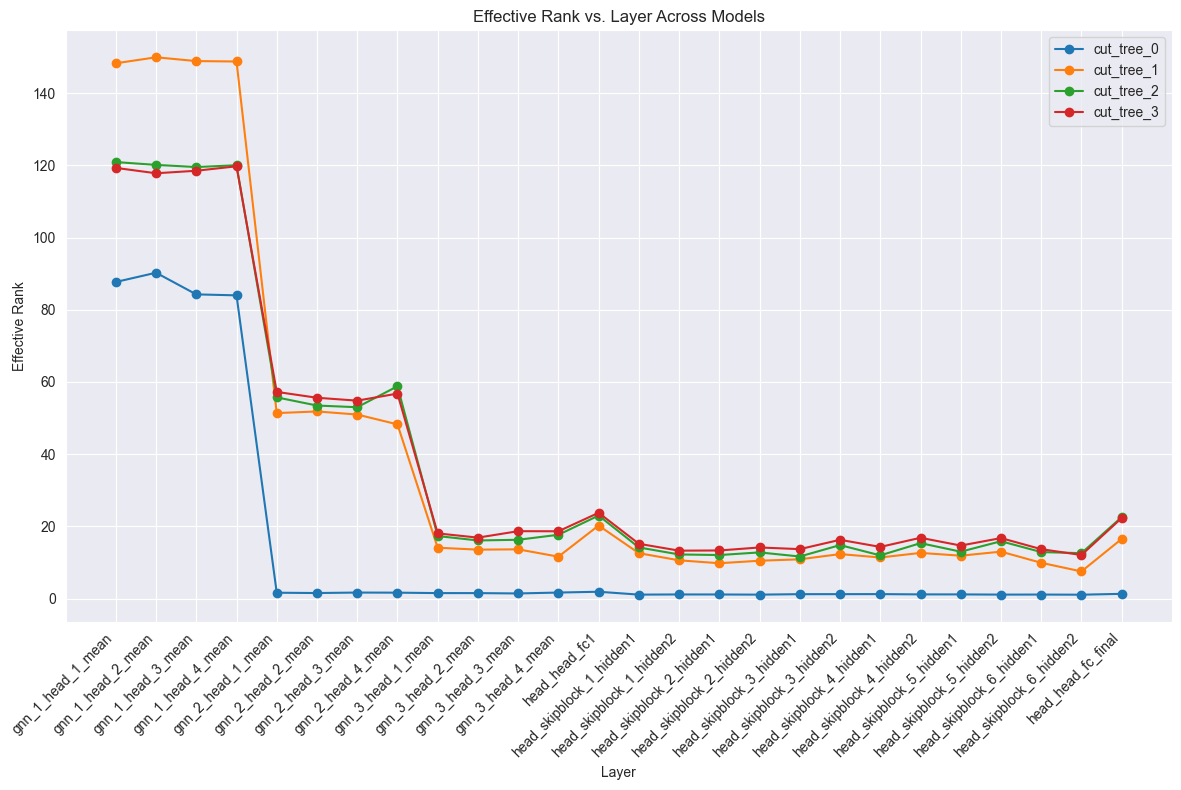

In [16]:
plot_effective_rank_vs_layer_multi(experiment_raw_spectra, layer_names, model_label_func=extract_label)

Processing experiments: 100%|██████████| 4/4 [00:27<00:00,  6.97s/it]


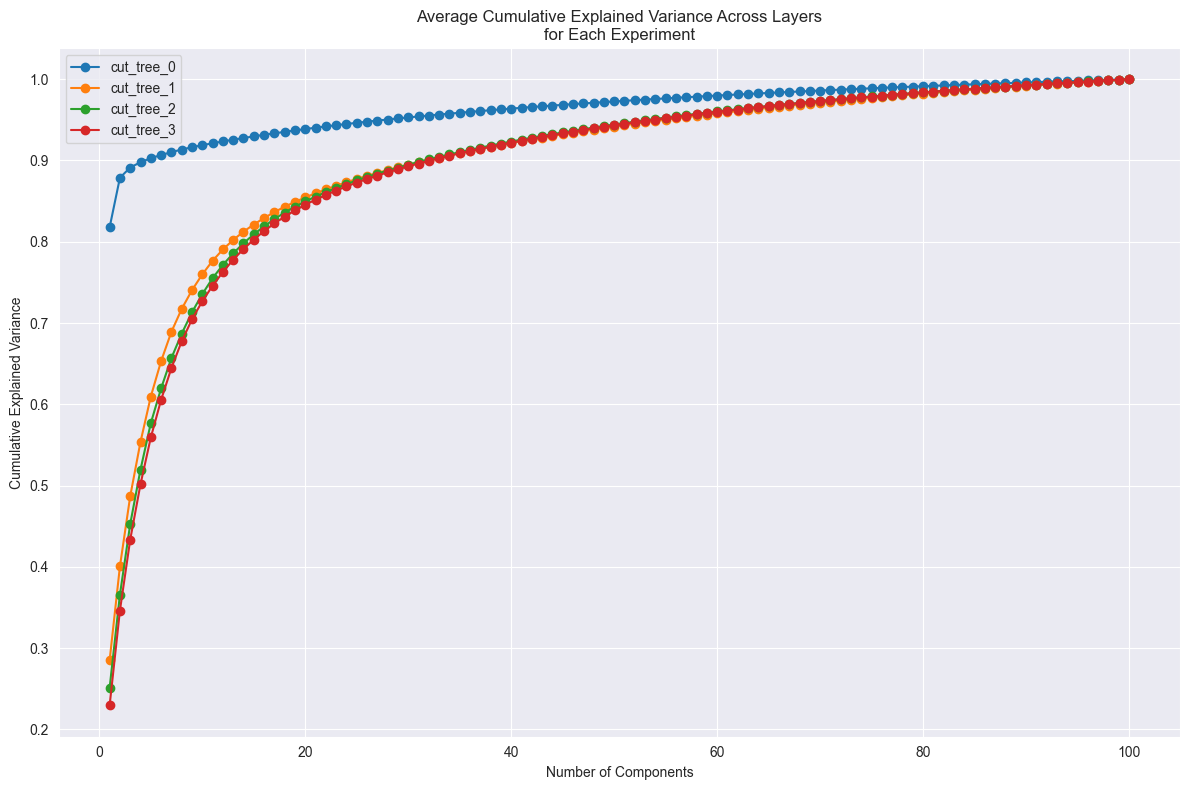

In [17]:
plot_avg_cum_explained_variance_multi(experiment_raw_spectra, layer_names, max_components=100, center=True, model_label_func=extract_label)

## Raw Spectra Bonus

In [18]:
experiment_raw_spectra_bonus = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_0_2025-02-19_11-44-59',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_1_2025-02-19_12-31-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_2_2025-02-19_13-16-56',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_3_2025-02-19_14-04-53'
]

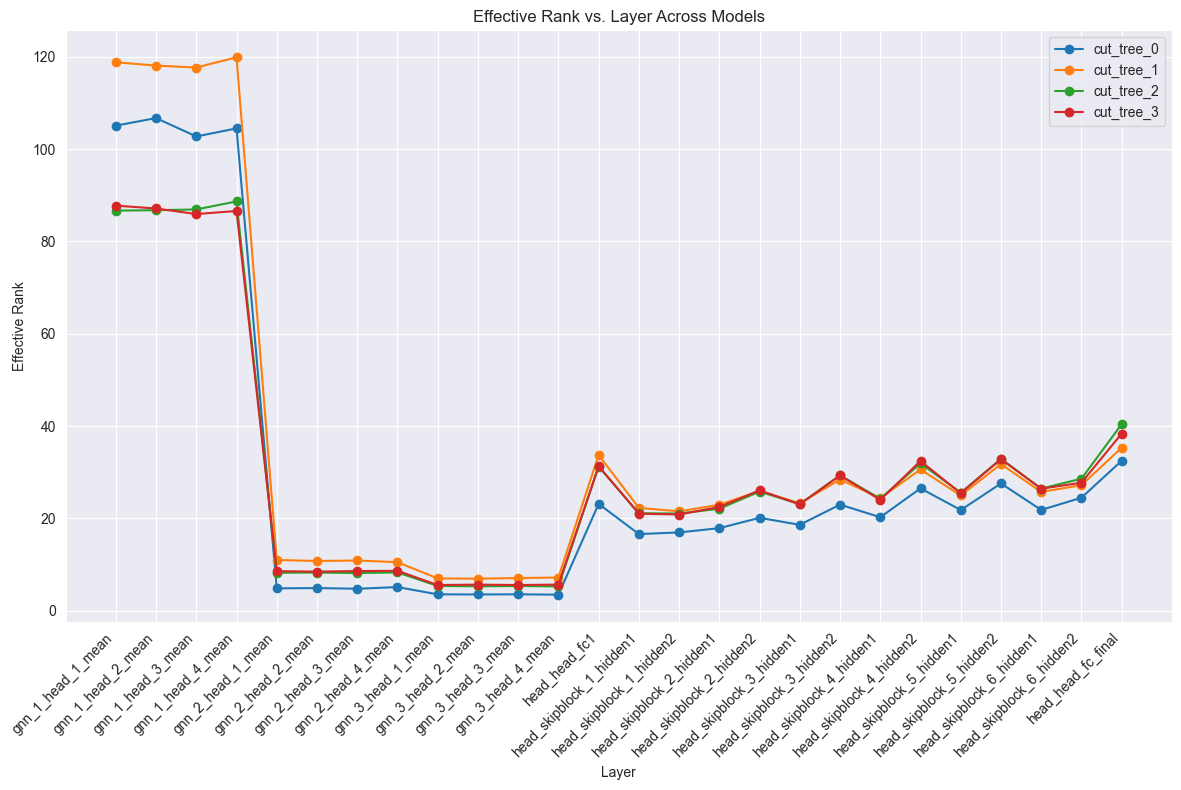

In [19]:
plot_effective_rank_vs_layer_multi(experiment_raw_spectra_bonus, layer_names, model_label_func=extract_label)

Processing experiments: 100%|██████████| 4/4 [00:27<00:00,  6.76s/it]


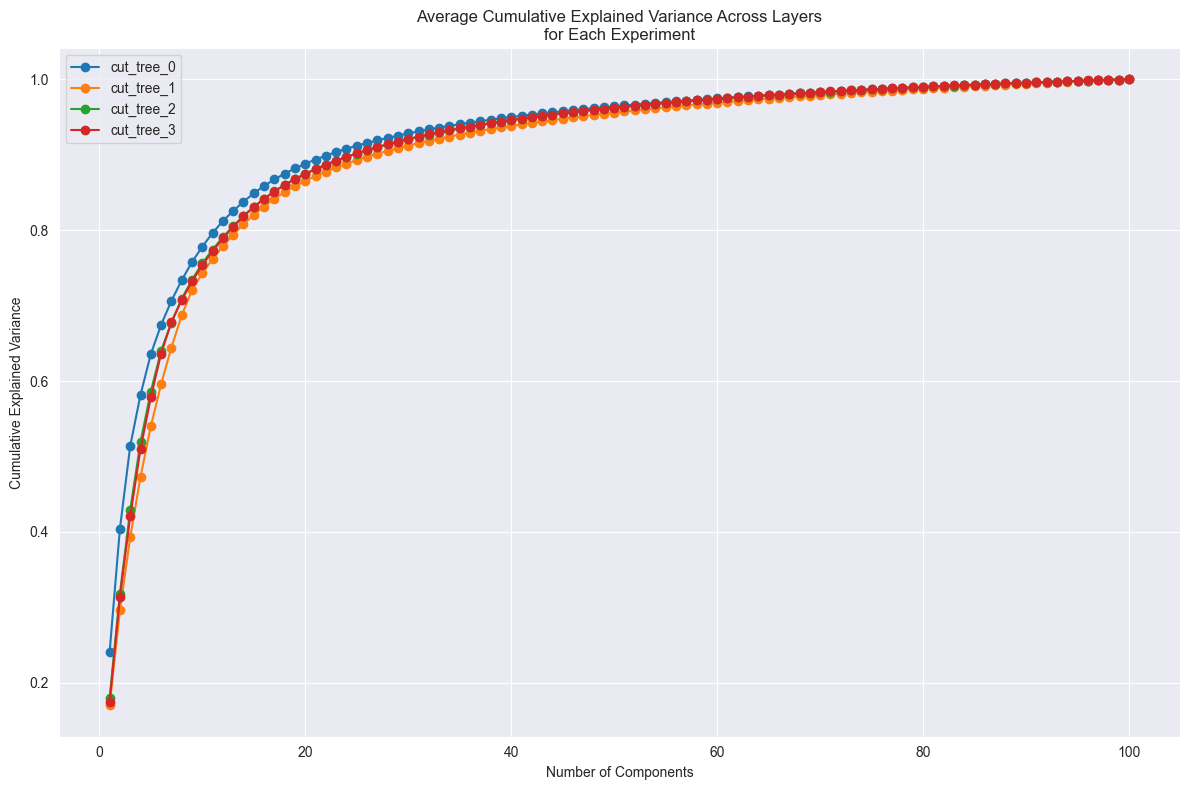

In [20]:
plot_avg_cum_explained_variance_multi(experiment_raw_spectra_bonus, layer_names, max_components=100, center=True, model_label_func=extract_label)

# Aggregate

In [51]:
def aggregate_effective_rank_for_type(exp_dirs, layer_names, center=True):
    """
    For a list of experiment directories (all for a given model type),
    compute the effective rank for each layer and average across experiments.
    
    Args:
        exp_dirs (list): List of experiment directory paths.
        layer_names (list): List of layer names.
        center (bool): Whether to center the embeddings.
        
    Returns:
        avg_eff_rank (np.ndarray): 1D array (length equal to number of layers) with the averaged effective rank.
    """
    eff_rank_list = []
    for exp_dir in exp_dirs:
        embeddings = load_embeddings(exp_dir, layer_names)
        eff_ranks = []
        for layer in layer_names:
            if layer in embeddings:
                sorted_eigvals = compute_sorted_eigenvalues(embeddings[layer], center=center)
                eff_rank = compute_effective_rank(sorted_eigvals)
                eff_ranks.append(eff_rank)
            else:
                eff_ranks.append(np.nan)
        eff_rank_list.append(np.array(eff_ranks))
    eff_rank_array = np.stack(eff_rank_list, axis=0)  # shape: [num_experiments, num_layers]
    avg_eff_rank = np.nanmean(eff_rank_array, axis=0)
    return avg_eff_rank

def aggregate_cum_explained_variance_for_type(exp_dirs, layer_names, max_components=100, center=True):
    """
    For a list of experiment directories (all for a given model type),
    compute the cumulative explained variance curve for each layer, average these curves
    over layers for each experiment, and then average across experiments.
    
    Args:
        exp_dirs (list): List of experiment directory paths.
        layer_names (list): List of layer names.
        max_components (int): Number of components to consider.
        center (bool): Whether to center the data.
        
    Returns:
        avg_curve (np.ndarray): 1D array (length = max_components) with the averaged cumulative explained variance curve.
    """
    curve_list = []
    for exp_dir in exp_dirs:
        embeddings = load_embeddings(exp_dir, layer_names)
        layer_curves = []
        for layer in layer_names:
            if layer in embeddings:
                emb = embeddings[layer]
                cum_explained = compute_cum_explained_variance(emb, center=center, max_components=max_components)
                layer_curves.append(cum_explained)
        if layer_curves:
            layer_curves = np.stack(layer_curves, axis=0)  # shape: [num_layers, max_components]
            avg_curve_exp = np.mean(layer_curves, axis=0)
            curve_list.append(avg_curve_exp)
    if curve_list:
        curve_array = np.stack(curve_list, axis=0)  # shape: [num_experiments, max_components]
        avg_curve = np.mean(curve_array, axis=0)
    else:
        avg_curve = np.zeros(max_components)
    return avg_curve

def plot_aggregated_metrics_by_type(experiment_types, layer_names, max_components=100, center=True, metric="effective_rank"):
    """
    Given a dictionary mapping model type labels to lists of experiment directories,
    aggregates the chosen metric (effective rank or cumulative explained variance) over experiments 
    for each model type and plots one curve per model type.
    
    Args:
        experiment_types (dict): Mapping from model type (str) to a list of experiment directories.
        layer_names (list): List of layer names.
        max_components (int): Number of components (only used for cumulative explained variance).
        center (bool): Whether to center the data.
        metric (str): "effective_rank" or "cum_explained".
    """
    agg_metric_dict = {}
    
    for model_type, exp_dirs in experiment_types.items():
        if metric == "effective_rank":
            avg_metric = aggregate_effective_rank_for_type(exp_dirs, layer_names, center=center)
            # For effective rank, x-axis will be layer indices
            x = np.arange(len(layer_names))
            agg_metric_dict[model_type] = (x, avg_metric)
        elif metric == "cum_explained":
            avg_metric = aggregate_cum_explained_variance_for_type(exp_dirs, layer_names, max_components=max_components, center=center)
            # For cumulative explained variance, x-axis is number of components.
            x = np.arange(1, max_components + 1)
            agg_metric_dict[model_type] = (x, avg_metric)
    
    plt.figure(figsize=(12, 8))
    for model_type, (x, y) in agg_metric_dict.items():
        plt.plot(x, y, marker='o', label=model_type)
    
    if metric == "effective_rank":
        plt.xlabel("Layer Index")
        plt.ylabel("Average Effective Rank")
        plt.title("Aggregated Effective Rank vs. Layer (by Model Type)")
        plt.xticks(x, layer_names, rotation=45, ha='right')
    elif metric == "cum_explained":
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("Aggregated Cumulative Explained Variance (by Model Type)")
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [52]:
experiment_types = {
    "dreams": experiment_dreams,               # list of directories for dreams embeddings
    "dreams_bonus": experiment_dreams_bonus,     # list of directories for dreams bonus embeddings
    "raw_spectra": experiment_raw_spectra,         # list of directories for raw spectra
    "raw_spectra_bonus": experiment_raw_spectra_bonus  # list of directories for raw spectra plus bonus
}


In [ ]:
# Then, to plot aggregated effective rank:
plot_aggregated_metrics_by_type(experiment_types, layer_names, metric="effective_rank")

In [ ]:
# And for cumulative explained variance:
plot_aggregated_metrics_by_type(experiment_types, layer_names, max_components=100, center=True, metric="cum_explained")

# By level

## level 2

In [34]:
experiment_level_2 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_0_2025-02-19_09-00-57',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_0_2025-02-19_11-44-59',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_14-51-13',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_0_2025-02-19_17-38-07',
]

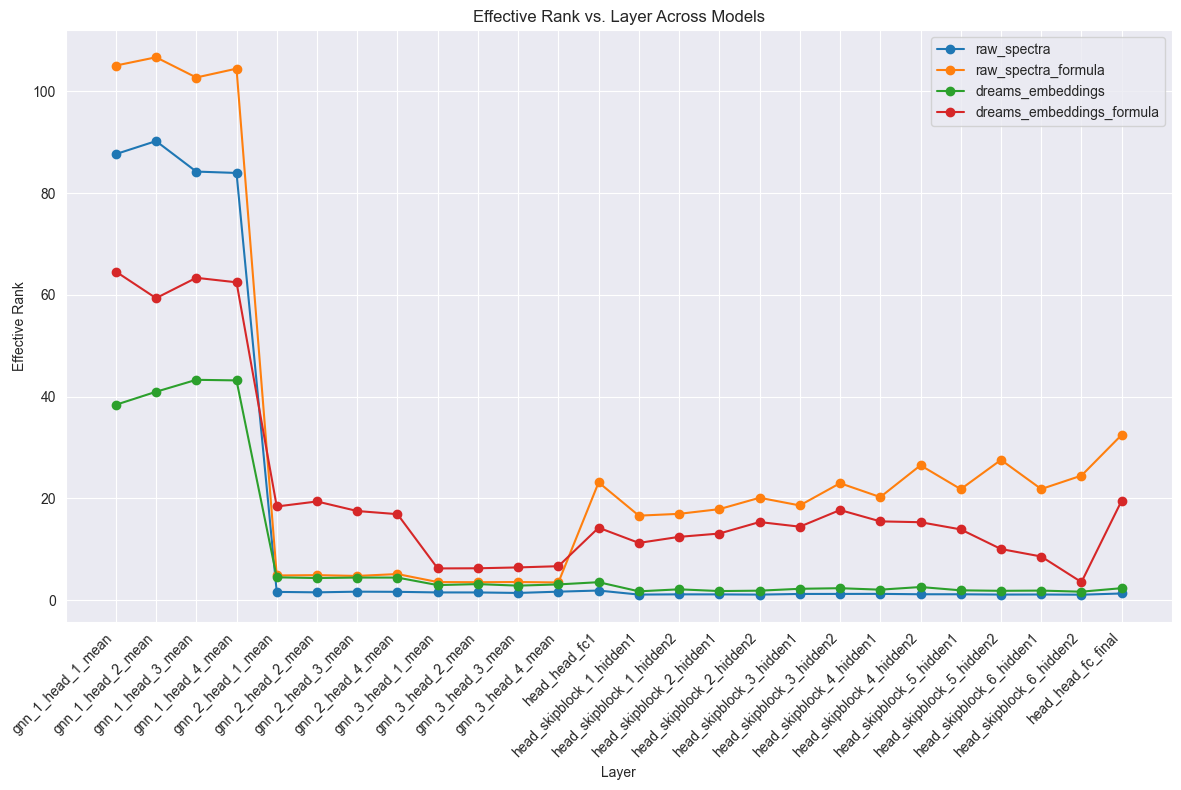

In [35]:
plot_effective_rank_vs_layer_multi(experiment_level_2, layer_names, model_label_func=same_depth_label)

Processing experiments: 100%|██████████| 4/4 [00:27<00:00,  6.90s/it]


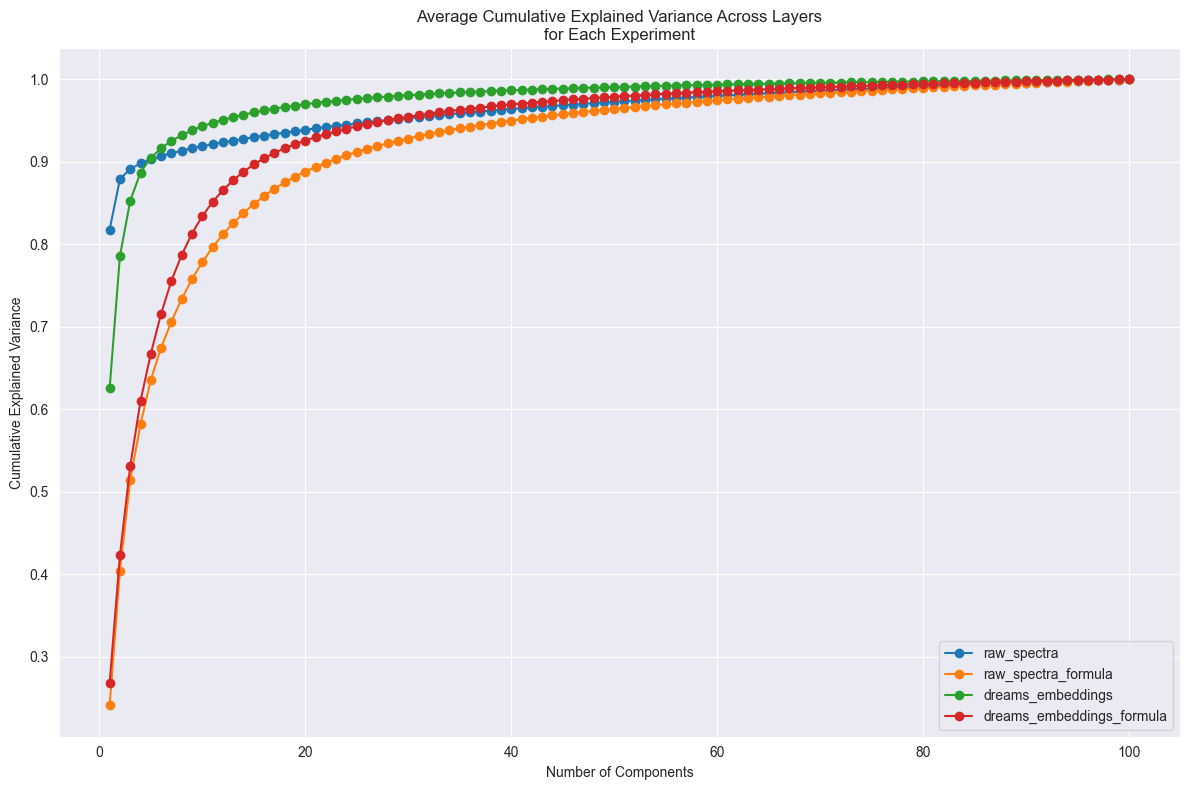

In [36]:
plot_avg_cum_explained_variance_multi(experiment_level_2, layer_names, max_components=100, center=True, model_label_func=same_depth_label)

## level 3

In [37]:
experiment_level_3 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_1_2025-02-19_09-38-36',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_1_2025-02-19_12-31-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_15-31-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_1_2025-02-19_18-24-19',
]

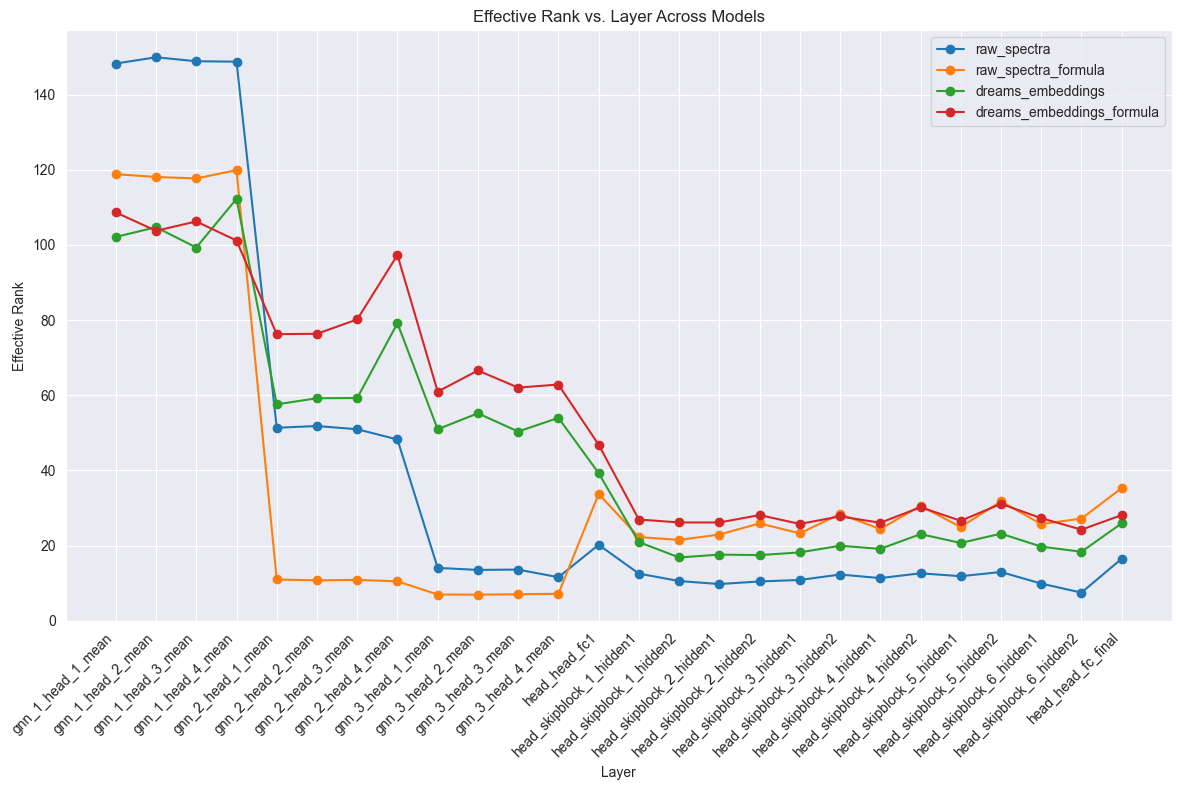

In [38]:
plot_effective_rank_vs_layer_multi(experiment_level_3, layer_names, model_label_func=same_depth_label)

Processing experiments: 100%|██████████| 4/4 [00:25<00:00,  6.30s/it]


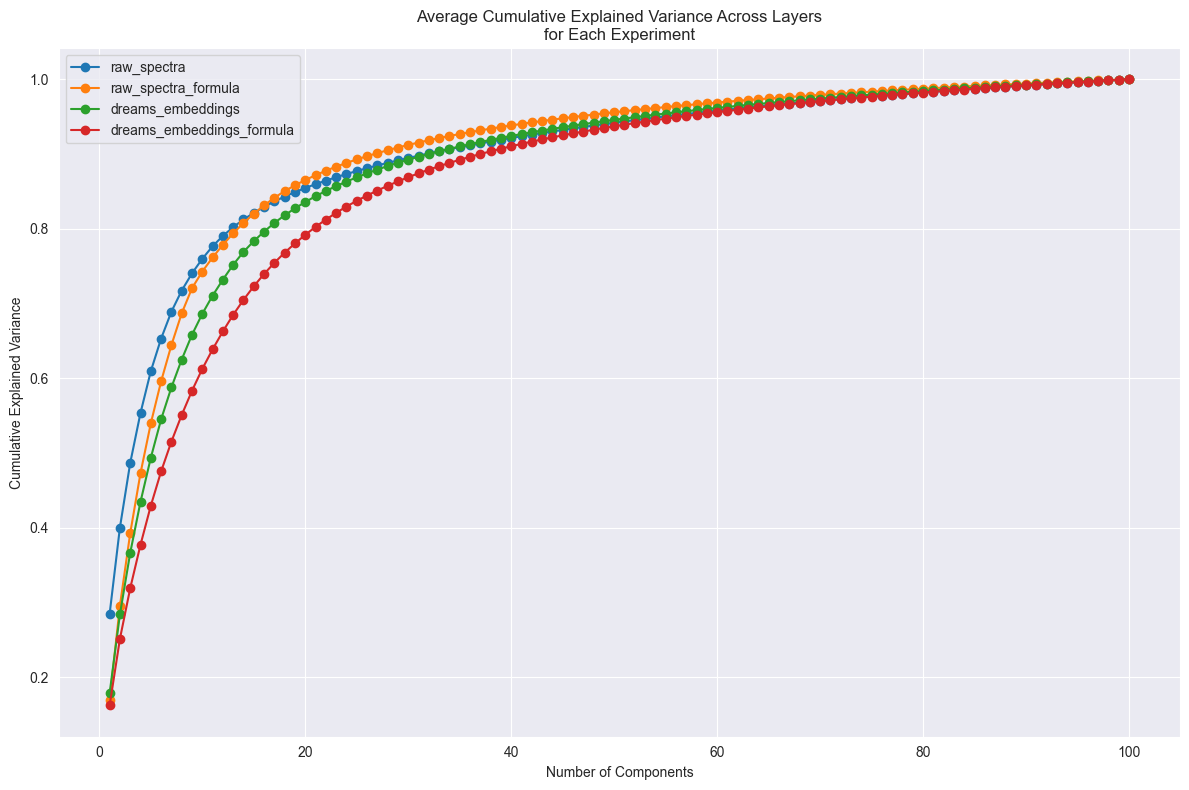

In [39]:
plot_avg_cum_explained_variance_multi(experiment_level_3, layer_names, max_components=100, center=True, model_label_func=same_depth_label)

## level 4

In [41]:
experiment_level_4 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_2_2025-02-19_10-20-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_2_2025-02-19_13-16-56',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_16-12-30',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_2_2025-02-19_19-10-33',
]

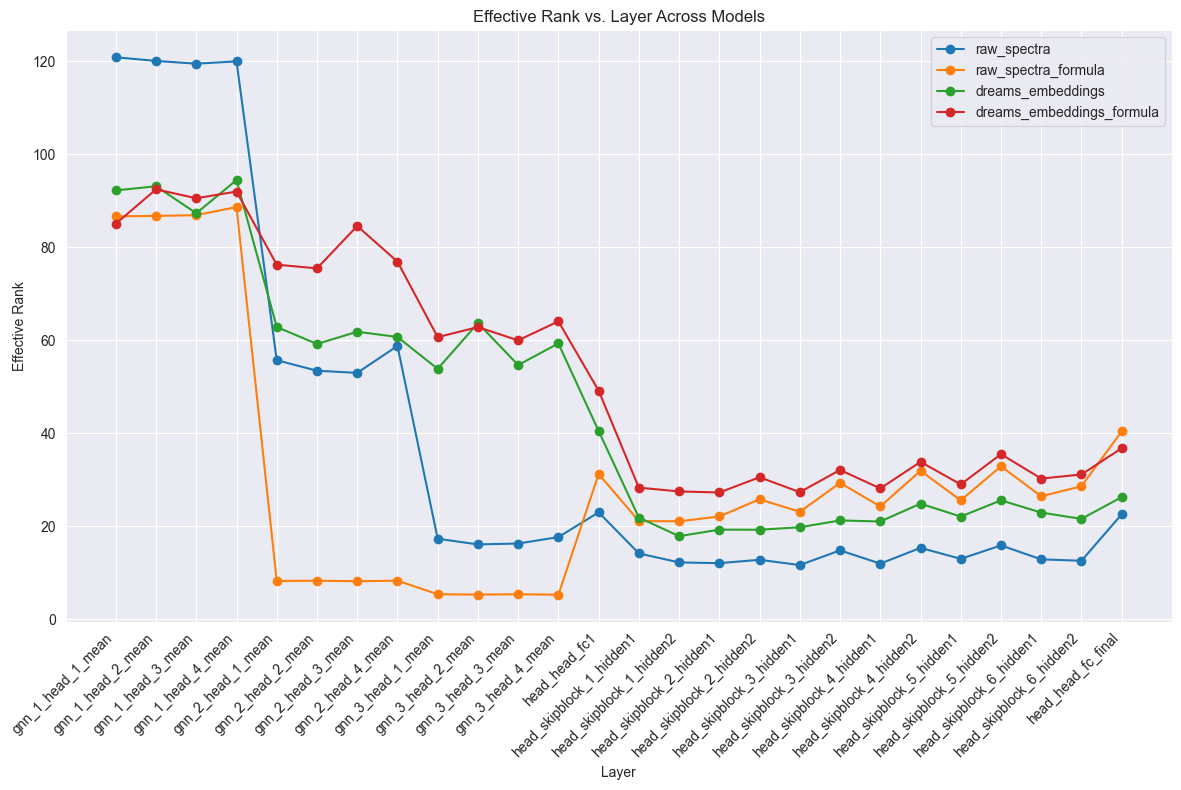

In [42]:
plot_effective_rank_vs_layer_multi(experiment_level_4, layer_names, model_label_func=same_depth_label)

Processing experiments: 100%|██████████| 4/4 [00:25<00:00,  6.31s/it]


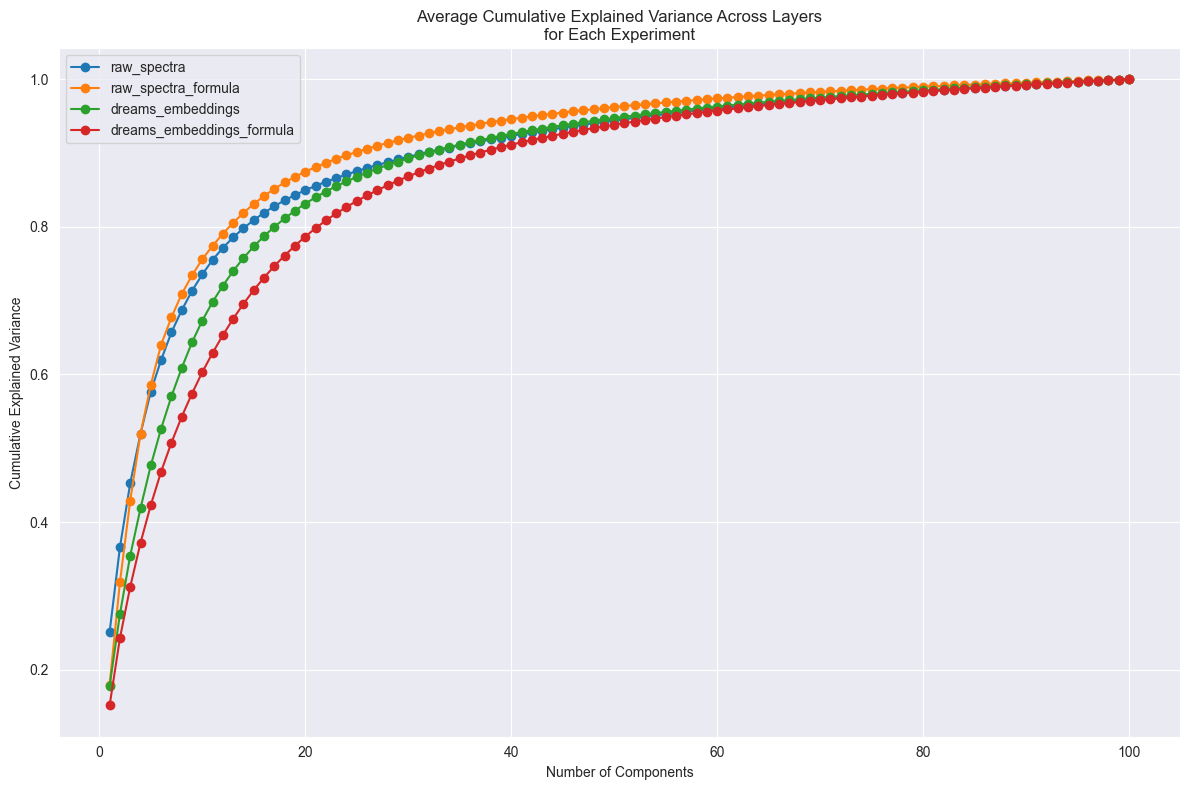

In [43]:
plot_avg_cum_explained_variance_multi(experiment_level_4, layer_names, max_components=100, center=True, model_label_func=same_depth_label)

# level 5

In [44]:
experiment_level_5 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_3_2025-02-19_11-02-28',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_3_2025-02-19_14-04-53',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_16-56-31',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_3_2025-02-19_19-57-08',
]

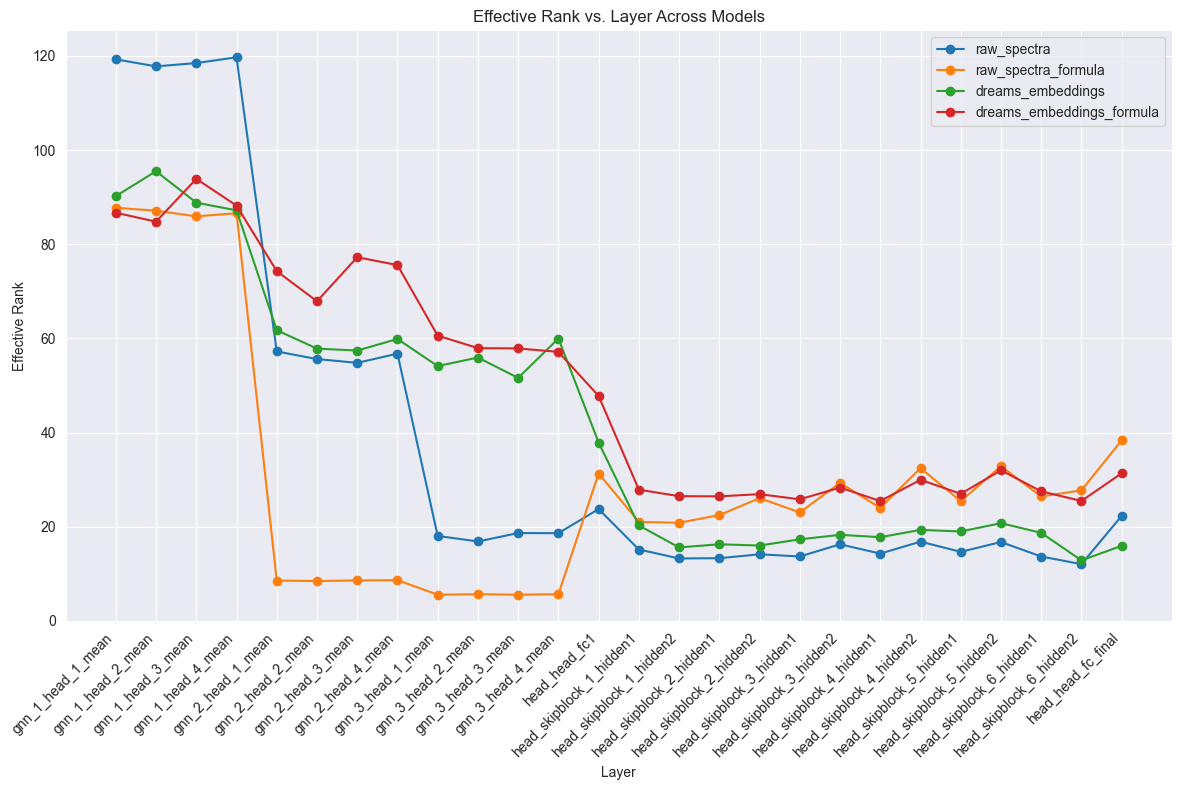

In [45]:
plot_effective_rank_vs_layer_multi(experiment_level_5, layer_names, model_label_func=same_depth_label)

Processing experiments: 100%|██████████| 4/4 [00:25<00:00,  6.30s/it]


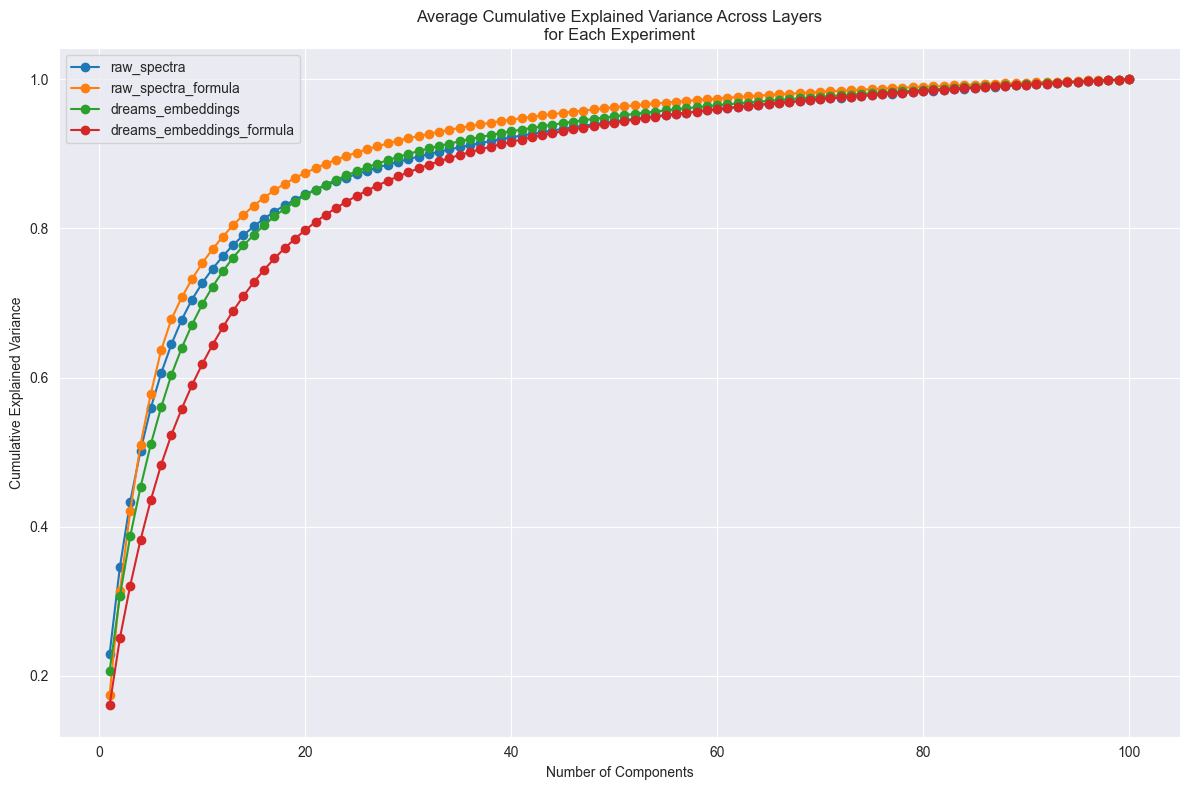

In [46]:
plot_avg_cum_explained_variance_multi(experiment_level_5, layer_names, max_components=100, center=True, model_label_func=same_depth_label)

# Aggregate by level 

In [47]:
def aggregate_effective_rank_for_level(exp_dirs, layer_names, center=True):
    """
    For a given list of experiment directories (all at the same ms level),
    compute the effective rank for each layer and average across experiments.
    
    Args:
        exp_dirs (list): List of experiment directory paths.
        layer_names (list): List of layer names.
        center (bool): Whether to center the embeddings.
        
    Returns:
        avg_eff_rank (np.ndarray): 1D array with the average effective rank per layer.
    """
    eff_rank_list = []
    for exp_dir in exp_dirs:
        embeddings = load_embeddings(exp_dir, layer_names)
        # Compute effective rank for each layer in this experiment.
        eff_ranks = []
        for layer in layer_names:
            if layer in embeddings:
                sorted_eigvals = compute_sorted_eigenvalues(embeddings[layer], center=center)
                eff_rank = compute_effective_rank(sorted_eigvals)
                eff_ranks.append(eff_rank)
            else:
                eff_ranks.append(np.nan)
        eff_rank_list.append(np.array(eff_ranks))
    # Average across experiments (ignoring NaNs).
    eff_rank_array = np.stack(eff_rank_list, axis=0)  # shape: [num_experiments, num_layers]
    avg_eff_rank = np.nanmean(eff_rank_array, axis=0)
    return avg_eff_rank

def aggregate_cum_explained_variance_for_level(exp_dirs, layer_names, max_components=100, center=True):
    """
    For a given list of experiment directories (all at the same ms level),
    compute the cumulative explained variance curve for each layer and average them.
    
    Args:
        exp_dirs (list): List of experiment directory paths.
        layer_names (list): List of layer names.
        max_components (int): Number of components to consider.
        center (bool): Whether to center the embeddings.
        
    Returns:
        avg_curve (np.ndarray): 1D array (length max_components) with the average cumulative explained variance.
    """
    curve_list = []
    for exp_dir in exp_dirs:
        embeddings = load_embeddings(exp_dir, layer_names)
        layer_curves = []
        for layer in layer_names:
            if layer in embeddings:
                emb = embeddings[layer]
                cum_explained = compute_cum_explained_variance(emb, center=center, max_components=max_components)
                layer_curves.append(cum_explained)
        if layer_curves:
            layer_curves = np.stack(layer_curves, axis=0)  # shape: [num_layers, max_components]
            # Average the curves for this experiment over layers.
            avg_curve_exp = np.mean(layer_curves, axis=0)
            curve_list.append(avg_curve_exp)
    if curve_list:
        curve_array = np.stack(curve_list, axis=0)  # shape: [num_experiments, max_components]
        # Average over experiments.
        avg_curve = np.mean(curve_array, axis=0)
    else:
        avg_curve = np.zeros(max_components)
    return avg_curve

def plot_aggregated_metrics_by_level(experiment_levels, layer_names, max_components=100, center=True, metric="effective_rank"):
    """
    Given a dictionary mapping ms level labels (e.g. "ms2", "ms3", etc.)
    to lists of experiment directories, aggregate the desired metric across
    experiments at the same level and plot one curve per level.
    
    Args:
        experiment_levels (dict): Mapping from level label (str) to list of experiment directories.
        layer_names (list): List of layer names.
        max_components (int): Number of components to consider (only used for cumulative explained variance).
        center (bool): Whether to center the data.
        metric (str): "effective_rank" or "cum_explained" to choose which metric to plot.
    """
    plt.figure(figsize=(12, 8))
    for level_label, exp_dirs in experiment_levels.items():
        if metric == "effective_rank":
            avg_metric = aggregate_effective_rank_for_level(exp_dirs, layer_names, center=center)
            x = np.arange(len(layer_names))
            plt.plot(x, avg_metric, marker='o', label=level_label)
        elif metric == "cum_explained":
            avg_metric = aggregate_cum_explained_variance_for_level(exp_dirs, layer_names, max_components=max_components, center=center)
            x = np.arange(1, max_components + 1)
            plt.plot(x, avg_metric, marker='o', label=level_label)
    if metric == "effective_rank":
        plt.xlabel("Layer")
        plt.ylabel("Average Effective Rank")
        plt.title("Average Effective Rank vs. Layer (Aggregated by ms level)")
        plt.xticks(x, layer_names, rotation=45, ha='right')
    elif metric == "cum_explained":
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("Average Cumulative Explained Variance (Aggregated by ms level)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [48]:

experiment_levels = {
    "ms2": experiment_level_2,  
    "ms3": experiment_level_3,
    "ms4": experiment_level_4,
    "ms5": experiment_level_5
}


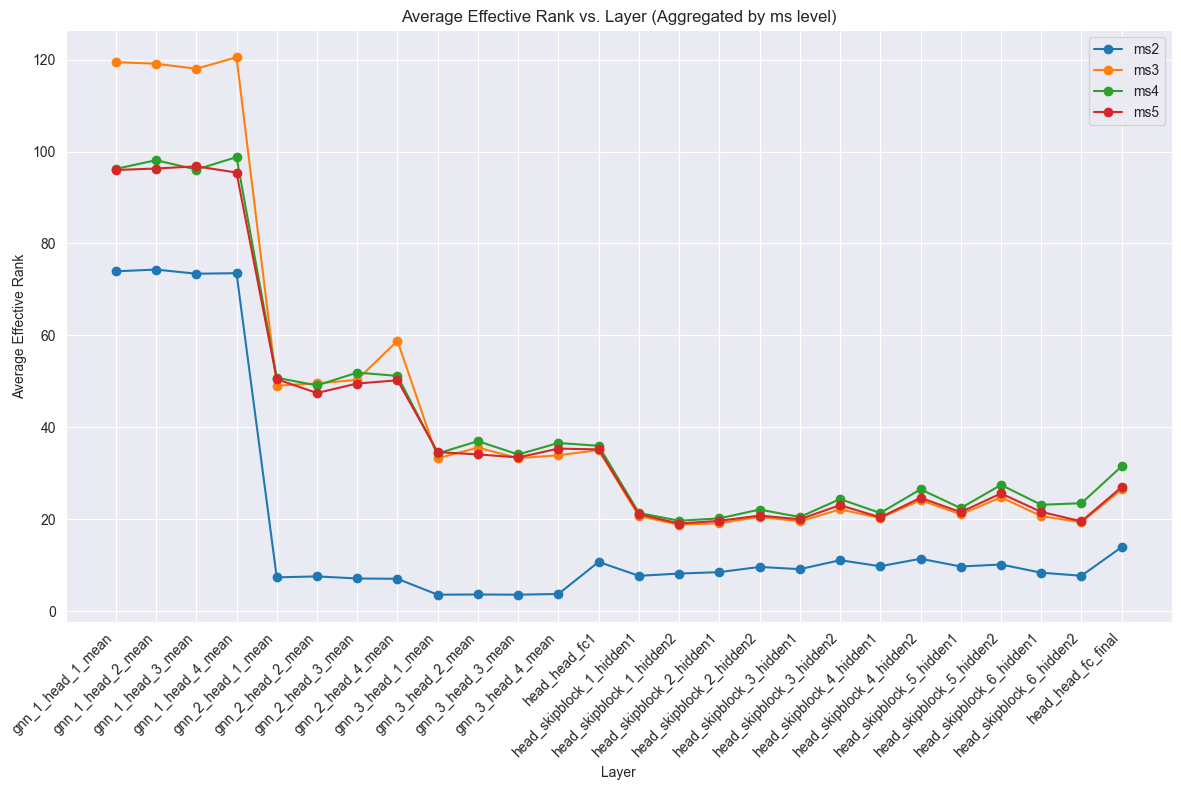

In [49]:
# Then, to plot aggregated effective rank curves:
plot_aggregated_metrics_by_level(experiment_levels, layer_names, metric="effective_rank")

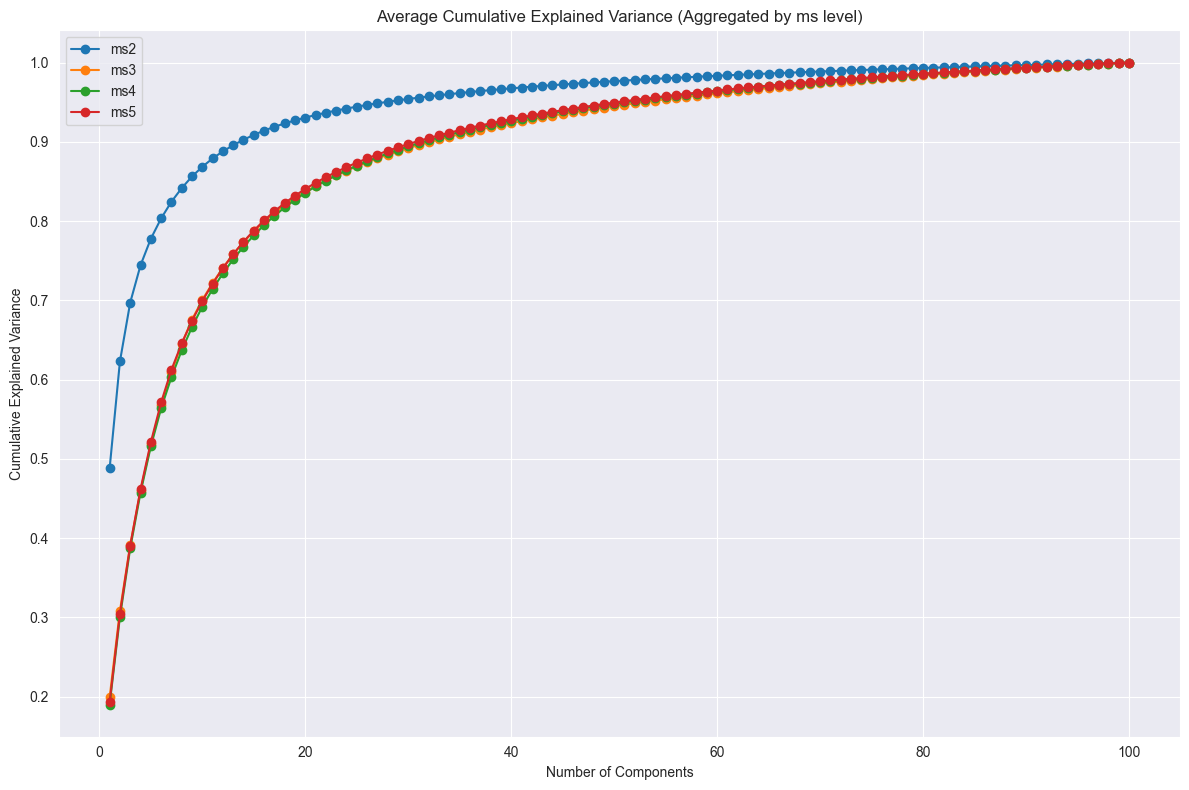

In [50]:
plot_aggregated_metrics_by_level(experiment_levels, layer_names, max_components=100, center=True, metric="cum_explained")